In [1]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tifffile
#dataset https://drive.google.com/file/d/1HWtBaSa-LTyAMgf2uaz1T9o1sTWDBajU/view


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np


def conv_block(inputs, filters, kernel_size=3):
    x = inputs
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters, kernel_size, kernel_initializer="he_normal",
                                   padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)  # Apply BatchNorm
        x = tf.keras.layers.Activation("relu")(x)
    return x


def encoder_block(inputs, filters=32):
    f = conv_block(inputs, filters=filters)  # output for the concat
    p = tf.keras.layers.MaxPooling2D((2, 2))(f)
    p = tf.keras.layers.Dropout(0.2)(p)
    return f, p


def encoder(inputs):
    filters = 32
    f1, p1 = encoder_block(inputs, filters)
    f2, p2 = encoder_block(p1, filters * 2)
    f3, p3 = encoder_block(p2, filters * 4)
    f4, p4 = encoder_block(p3, filters * 8)
    return p4, (f1, f2, f3, f4)


def bottleneck(inputs):
    bottle_neck = conv_block(inputs, 512)
    return bottle_neck


def decoder_block(inputs, conv_out, filters=256, kernel_size=3, strides=2):
    u = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides, padding="same")(inputs)
    cat = tf.keras.layers.concatenate([u, conv_out])
    cat = tf.keras.layers.Dropout(0.2)(cat)
    cat = conv_block(cat, filters, kernel_size)
    return cat


def decoder(inputs, convs, out_channels, filters=256):
    f1, f2, f3, f4 = convs

    c6 = decoder_block(inputs, f4, filters)
    c7 = decoder_block(c6, f3, filters / 2)
    c8 = decoder_block(c7, f2, filters / 4)
    c9 = decoder_block(c8, f1, filters / 8)

    outputs = tf.keras.layers.Conv2D(out_channels, 1, activation="softmax")(c9)
    return outputs


In [3]:
OUTPUT_CHANNELS=4
def unet():
    
    inputs= tf.keras.layers.Input(shape=(128, 128, 1))
    #inputs= tf.keras.layers.Lambda(lambda x: x/255)(inputs)
    encoder_output, convs = encoder(inputs)
    bottle_neck= bottleneck(encoder_output)
    outputs= decoder(bottle_neck, convs, OUTPUT_CHANNELS)
    model= tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model= unet()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 batch_normalization_8 (BatchNo  (None, 8, 8, 512)   2048        ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 8, 8, 512)    0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 8, 8, 512)    2359808     ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 8, 8, 512)   2048        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
          

                                )                                 'activation_1[0][0]']           
                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 64  0           ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 32  18464       ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 128, 128, 32  128        ['conv2d_16[0][0]']              
 ormalization)                  )                                                                 
          

In [4]:
SIZE_X=128
SIZE_Y= 128

In [5]:
###### Read and convert stacked tiff images into numpy array for images and masks
###### Beware to read it as grayscale 
###### otherwise it wont work

In [6]:
file_path = "images/images_as_128x128_patches.tif"

# Read the TIF file containing stacked images
stacked_image = tifffile.imread(file_path)

# Get the number of images in the stacked image
num_images = stacked_image.shape[0]

# Create an empty array to store individual images
train_images = []

# Iterate over each image and append it to the array
for i in range(num_images):
    # Read each image in grayscale
    image = stacked_image[i, :, :]
    
    # Append the grayscale image to the array
    train_images.append(image)
train_images= np.array(train_images)

In [7]:
train_images.shape

(1600, 128, 128)

In [8]:
train_images

array([[[117, 124, 127, ..., 116, 138, 140],
        [122, 123, 123, ..., 114, 125, 128],
        [124, 124, 122, ..., 125, 121, 111],
        ...,
        [ 92,  71,  55, ..., 157, 135, 121],
        [131, 115,  91, ..., 144, 127, 116],
        [135, 140, 138, ..., 135, 124, 120]],

       [[ 27,  30,  44, ...,  56,  59,  78],
        [ 31,  35,  48, ...,  44,  48,  62],
        [ 38,  37,  55, ...,  28,  37,  49],
        ...,
        [127, 123, 118, ..., 132, 131, 122],
        [124, 122, 116, ..., 133, 128, 128],
        [114, 113, 117, ..., 117, 115, 122]],

       [[130, 134, 129, ..., 115, 116, 111],
        [124, 122, 128, ..., 122, 118, 112],
        [119, 122, 129, ..., 115, 116, 118],
        ...,
        [ 59,  60,  78, ..., 114, 124, 121],
        [ 39,  49,  62, ..., 116, 111, 116],
        [ 40,  41,  45, ..., 136, 121, 121]],

       ...,

       [[127, 124, 123, ..., 122, 109, 120],
        [126, 123, 116, ..., 124, 116, 115],
        [128, 132, 119, ..., 125, 122, 116

In [9]:
file_path = "masks/masks_as_128x128_patches.tif"

# Read the TIF file containing stacked images
stacked_image = tifffile.imread(file_path)

# Get the number of images in the stacked image
num_images = stacked_image.shape[0]

# Create an empty array to store individual images
train_masks = []

# Iterate over each image and append it to the array
for i in range(num_images):
    # Read each image in grayscale
    image = stacked_image[i, :, :]
    
    # Append the grayscale image to the array
    train_masks.append(image)
train_masks= np.array(train_masks)

In [10]:
train_masks.shape

(1600, 128, 128)

In [11]:
train_masks

array([[[3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]],

       [[1, 1, 1, ..., 1, 1, 2],
        [1, 1, 1, ..., 1, 1, 2],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]],

       [[3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [2, 2, 2, ..., 3, 3, 3],
        [1, 1, 2, ..., 3, 3, 3],
        [1, 1, 1, ..., 3, 3, 3]],

       ...,

       [[3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]],

       [[3, 3, 3, ..., 1, 2, 2],
        [3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 1, 1, 1],
        ...,
        [3, 3, 3, ..., 

In [12]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks = train_masks.reshape(-1,1)
train_masks = labelencoder.fit_transform(train_masks)


train_masks = train_masks.reshape(n, h, w)

np.unique(train_masks)

C:\Users\jpolo\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3], dtype=int64)

In [13]:
train_masks.shape

(1600, 128, 128)

In [14]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks = np.expand_dims(train_masks, axis=3)

In [15]:
train_images.shape

(1600, 128, 128, 1)

In [16]:
train_masks.shape

(1600, 128, 128, 1)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks, test_size = 0.20, random_state = 42)

In [18]:
print("Class values in the dataset are ... ", np.unique(y_train))  

Class values in the dataset are ...  [0 1 2 3]


In [19]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, 4)

In [20]:
train_masks_cat.shape

(1280, 128, 128, 4)

In [21]:
test_masks_cat = to_categorical(y_test, 4)


In [22]:
test_masks_cat.shape

(320, 128, 128, 4)

In [23]:
####Ready to model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [24]:
history = model.fit(X_train, train_masks_cat, 
                    batch_size = 32, 
                    verbose=1, 
                    epochs=50,  
                    shuffle=False)

Epoch 1/50
40/40 [==============================] - 145s 4s/step - loss: 0.9115 - accuracy: 0.7558
Epoch 2/50
40/40 [==============================] - 147s 4s/step - loss: 0.5230 - accuracy: 0.8807
Epoch 3/50
40/40 [==============================] - 152s 4s/step - loss: 0.3808 - accuracy: 0.9110
Epoch 4/50
40/40 [==============================] - 140s 4s/step - loss: 0.3272 - accuracy: 0.9120
Epoch 5/50
40/40 [==============================] - 135s 3s/step - loss: 0.2520 - accuracy: 0.9288
Epoch 6/50
40/40 [==============================] - 137s 3s/step - loss: 0.2120 - accuracy: 0.9361
Epoch 7/50
40/40 [==============================] - 139s 3s/step - loss: 0.1886 - accuracy: 0.9398
Epoch 8/50
40/40 [==============================] - 136s 3s/step - loss: 0.1734 - accuracy: 0.9425
Epoch 9/50
40/40 [==============================] - 140s 3s/step - loss: 0.1604 - accuracy: 0.9451
Epoch 10/50
40/40 [==============================] - 143s 4s/step - loss: 0.1505 - accuracy: 0.9473
Epoch 11/

In [26]:
model.save('test_50.hdf5')

In [25]:
_, acc = model.evaluate(X_test, test_masks_cat)
print("Accuracy is = ", (acc * 100.0), "%")


10/10 [==============================] - 6s 613ms/step - loss: 0.1350 - accuracy: 0.9563
Accuracy is =  95.63480615615845 %


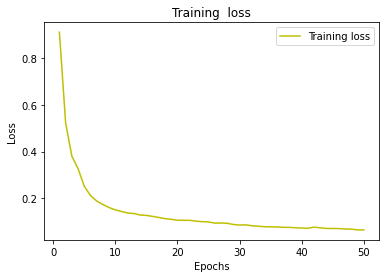

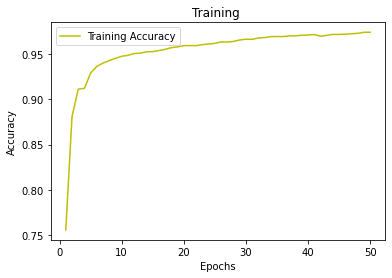

In [27]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training  loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']


plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.title('Training ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

10/10 [==============================] - 6s 597ms/step
Mean IoU = 0.8410237


[[6.37976e+05 2.32550e+04 2.88460e+04 5.90000e+01]
 [1.62080e+04 2.98180e+05 1.25367e+05 4.00000e+00]
 [3.13600e+03 1.43840e+04 3.94036e+06 1.65830e+04]
 [1.70000e+01 0.00000e+00 1.00300e+03 1.37502e+05]]
IoU for class1 is:  0.8991948
IoU for class2 is:  0.62459415
IoU for class3 is:  0.95415646
IoU for class4 is:  0.8861492


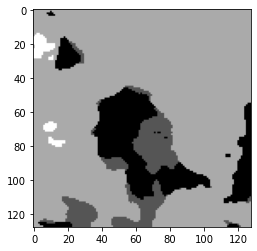

In [29]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

1/1 [==============================] - 0s 290ms/step


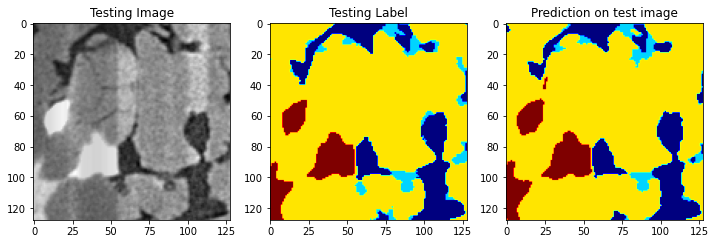

1/1 [==============================] - 0s 40ms/step


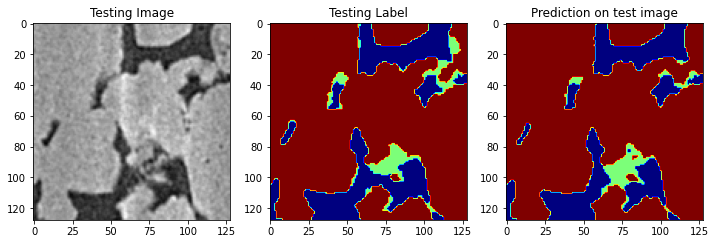

1/1 [==============================] - 0s 47ms/step


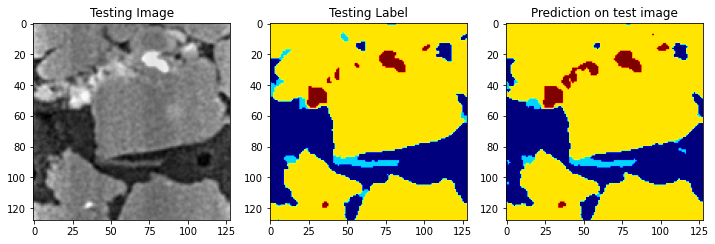

1/1 [==============================] - 0s 50ms/step


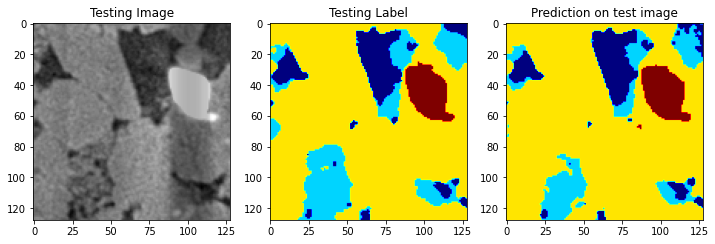

1/1 [==============================] - 0s 36ms/step


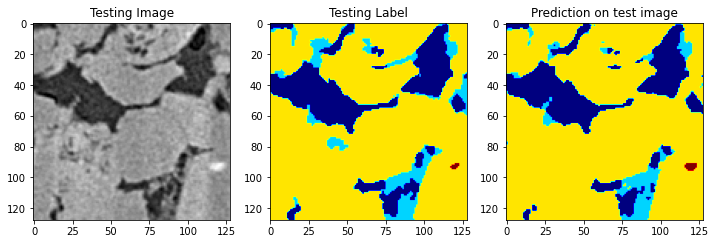

1/1 [==============================] - 0s 50ms/step


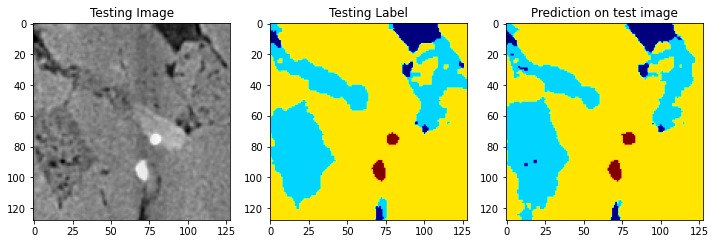

1/1 [==============================] - 0s 43ms/step


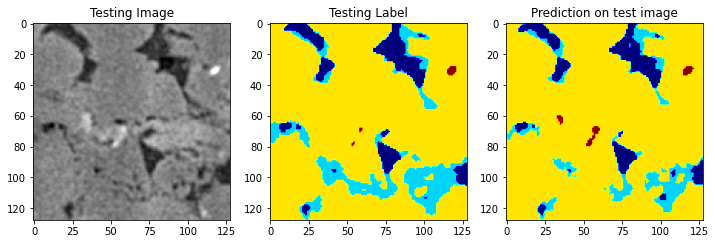

1/1 [==============================] - 0s 35ms/step


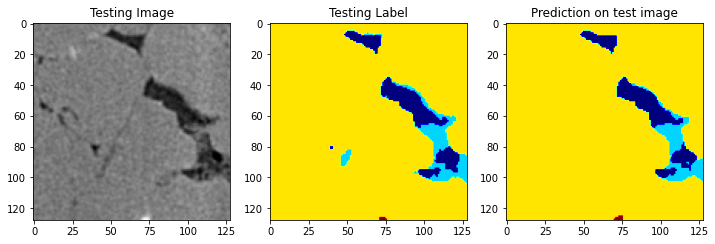

1/1 [==============================] - 0s 40ms/step


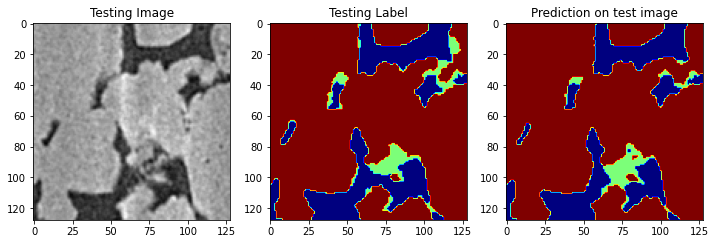

1/1 [==============================] - 0s 49ms/step


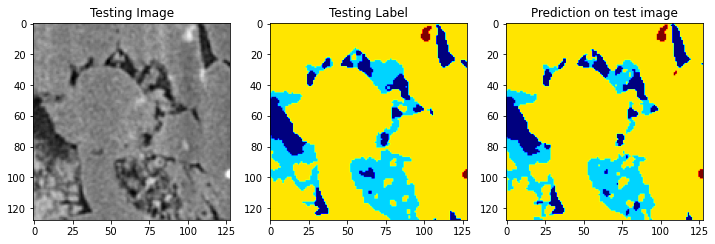

1/1 [==============================] - 0s 41ms/step


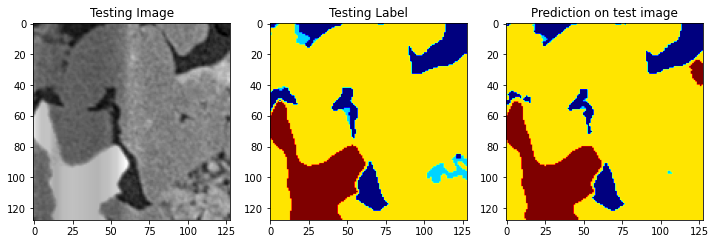

1/1 [==============================] - 0s 36ms/step


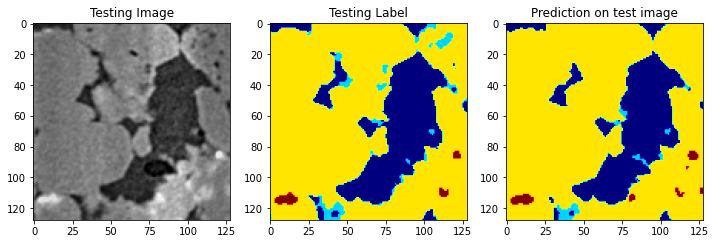

1/1 [==============================] - 0s 44ms/step


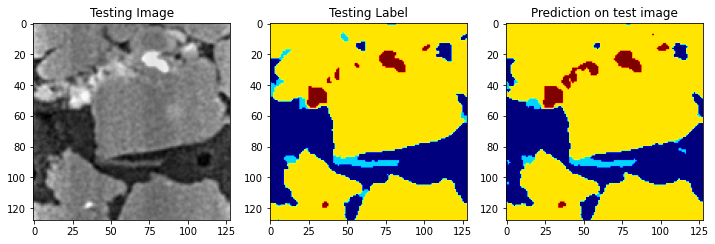

1/1 [==============================] - 0s 40ms/step


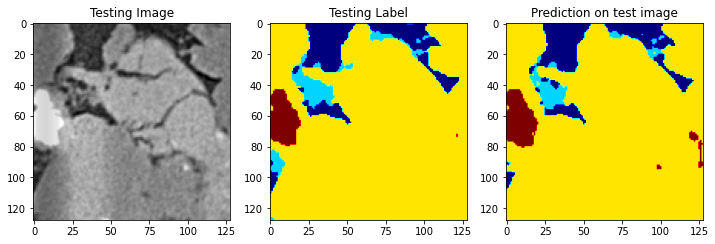

1/1 [==============================] - 0s 40ms/step


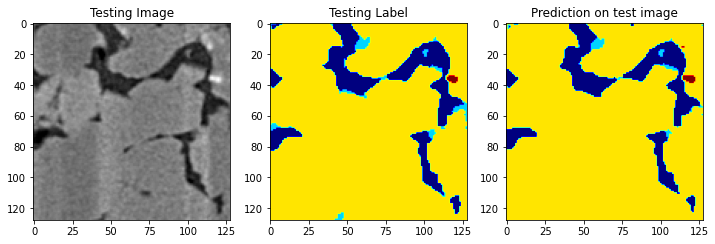

In [30]:
import random
for i in range(15):
    
    test_img_number = random.randint(0, len(X_test))
    test_img = X_test[test_img_number]
    ground_truth=y_test[test_img_number]
    test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img_norm, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]


    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='jet')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, cmap='jet')
    plt.show()


In [35]:
import cv2
import numpy as np
from tifffile import imread, imsave
from skimage.util import img_as_ubyte
from skimage.transform import resize
from patchify import patchify, unpatchify

In [45]:
file_path = "all_images/sandstone_all_462_images.tif"

# Read the TIF file containing stacked images
stacked_image = imread(file_path)

# Reshape the images to 1024x1024
resized_images = []
for i in range(stacked_image.shape[0]):
    resized_img = resize(stacked_image[i], (1024, 1024), preserve_range=True)
    resized_images.append(resized_img.astype(np.uint8))
    
stacked_image = np.array(resized_images)

# Get the number of images in the stacked image
num_images = stacked_image.shape[0]



In [46]:
stacked_image

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
# Create an empty array to store individual images
segm_images = []

# Iterate over each image
for i in range(num_images):
    # Read each image in grayscale
    image = stacked_image[i, :, :]
    patches = patchify(image, (128, 128), step=128)
  
    predicted_patches = []
    for j in range(patches.shape[0]):
        for k in range(patches.shape[1]):
            single_patch = patches[j, k, :, :]
            
            single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1), 2)
            single_patch_input = np.expand_dims(single_patch_norm, 0)
    
            single_patch_prediction = model.predict(single_patch_input)
            single_patch_predicted_img = np.argmax(single_patch_prediction, axis=3)[0, :, :]
    
            predicted_patches.append(single_patch_predicted_img)
    
    predicted_patches = np.array(predicted_patches)
    
    predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 128, 128))
    
    reconstructed_image = unpatchify(predicted_patches_reshaped, image.shape)
    
    segm_images.append(reconstructed_image)
    
    
final_segm_image = np.array(segm_images).astype(np.uint8)

imsave('segmented_images/sandstone_segmented_test.tif', final_segm_image)

1/1 [==============================] - 0s 232ms/step


1/1 [==============================] - 0s 232ms/step


1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 240ms/step


1/1 [==============================] - 0s 232ms/step


1/1 [==============================] - 0s 231ms/step


1/1 [==============================] - 0s 223ms/step


1/1 [==============================] - 0s 216ms/step


1/1 [==============================] - 0s 232ms/step


1/1 [==============================] - 0s 232ms/step


1/1 [==============================] - 0s 232ms/step


1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 240ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 242ms/step


1/1 [==============================] - 0s 238ms/step


1/1 [==============================] - 0s 229ms/step


1/1 [==============================] - 0s 233ms/step


1/1 [==============================] - 0s 212ms/step


1/1 [==============================] - 0s 229ms/step


1/1 [==============================] - 0s 227ms/step
